# Preparation

In [22]:
%run Utilities/Preparation.ipynb
df152 = pd.read_csv("../data/2017-09-05.1.52.csv")
df152 = df152.rename(index=str, columns={'playerId': 'sessionId'})

# Player filtering

In [23]:
players = df152.loc[:, playerFilteringColumns]
players = players.dropna(how='any')
players.head()

,sessionId,customData.localplayerguid,customData.platform,serverTime
0,b724663c-b32a-4079-9f8f-896762b272d1,"""4dbc2f43-421c-4e23-85d4-f17723ff8c66""","""webglplayer""",2017-04-12T08:57:48.448Z
3,b724663c-b32a-4079-9f8f-896762b272d1,"""4dbc2f43-421c-4e23-85d4-f17723ff8c66""","""webglplayer""",2017-04-12T08:58:37.640Z
4,2d76c4ef-f260-4963-82f4-ff598d2a63b4,"""1a8924de-7cc6-4ff5-8735-4cddac309117""","""webglplayer""",2017-04-12T09:30:51.879Z
67,6a9893c1-da09-42c7-832e-4d0746fa779e,"""1a8924de-7cc6-4ff5-8735-4cddac309117""","""webglplayer""",2017-04-12T09:46:31.313Z
74,c430c60c-d7cb-4fc5-893b-dce440696caf,"""a6483353-5db1-4c6c-98d7-b6328d0f4456""","""webglplayer""",2017-04-12T10:58:14.457Z


In [24]:
players.shape[0]

504

In [25]:
players = players[~players['customData.localplayerguid'].isin(excludedIDs)];
players.shape[0]

488

## Sessions (filtered)

In [26]:
sessionscount = players["sessionId"].nunique()
sessionscount

424

## Sessions of dev IDs

## Unique players

In [27]:
uniqueplayers = players['customData.localplayerguid']
uniqueplayers = uniqueplayers.unique()
uniqueplayers.shape[0]

243

In [28]:
#uniqueplayers

## Unique platforms

In [29]:
uniqueplatforms = players['customData.platform'].unique()
uniqueplatforms

array(['"webglplayer"', '"windowsplayer"', '"windowseditor"', '"android"',
       '"osxeditor"', '"linuxplayer"', '"osxplayer"'], dtype=object)

## Checkpoints passed / furthest checkpoint (unfiltered)

In [30]:
checkpoints = df152.loc[:, checkpointsRelevantColumns]
checkpoints = checkpoints[checkpoints['type']=='reach'].loc[:,['section','sessionId']]
checkpoints = checkpoints[checkpoints['section'].str.startswith('tutorial', na=False)]
checkpoints = checkpoints.groupby("sessionId")
checkpoints = checkpoints.max()
checkpoints.head()

,section
sessionId,
002caea8-9a7f-436e-be1d-aa15eb0e422b,tutorial1.Checkpoint14
01eefc09-2d17-4669-9b66-1873ded5ba7e,tutorial1.Checkpoint00
0229d38c-72e9-47d2-b5eb-9adc774e9be9,tutorial1.Checkpoint00
02c951e6-1e39-4ed7-a884-acc38757a473,tutorial1.Checkpoint00
0405e80c-bfb5-4c63-af00-ed60f6e80c55,tutorial1.Checkpoint00


In [31]:
maxCheckpointTable = pd.DataFrame({"maxCheckpoint" : checkpoints.values.flatten()})
maxCheckpointCounts = maxCheckpointTable["maxCheckpoint"].value_counts()
maxCheckpointCounts['Start'] = None
maxCheckpointCounts = maxCheckpointCounts.sort_index()
print '\nmaxCheckpointCounts=\n{0}'.format(maxCheckpointCounts)


maxCheckpointCounts=
Start                     None
tutorial1.Checkpoint00      41
tutorial1.Checkpoint01      85
tutorial1.Checkpoint02      13
tutorial1.Checkpoint03       4
tutorial1.Checkpoint04      29
tutorial1.Checkpoint05       5
tutorial1.Checkpoint06       8
tutorial1.Checkpoint07       2
tutorial1.Checkpoint08       2
tutorial1.Checkpoint09       1
tutorial1.Checkpoint10       1
tutorial1.Checkpoint13       3
tutorial1.Checkpoint14      29
Name: maxCheckpoint, dtype: object


In [32]:
%run Utilities/Plot.ipynb

In [33]:
maxCheckpointCountsTable = pd.DataFrame({"maxCheckpoint" : maxCheckpointCounts.values})
maxCheckpointCountsTableCount = maxCheckpointCountsTable.sum(0)[0]
maxCheckpointCountsTableCount

223.0

In [34]:
checkpoints.count()

section    223
dtype: int64

In [35]:
maxCheckpointCountsTable.head()

,maxCheckpoint
0,None
1,41
2,85
3,13
4,4


In [36]:
maxCheckpointCountsTable.describe()

,maxCheckpoint
count,13
unique,10
top,29
freq,2


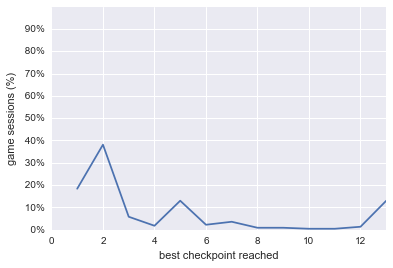

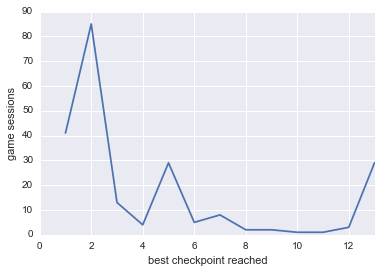

In [37]:
genericTreatment( maxCheckpointCountsTable, "best checkpoint reached", "game sessions", 0, maxCheckpointCountsTableCount, False, True )

## Session starts

In [38]:
#starts = df152.loc[:, checkpointsRelevantColumns]
#starts = checkpoints[checkpoints['type']=='start'].loc[:,['playerId']]
#starts = checkpoints[checkpoints['section'].str.startswith('tutorial', na=False)]
#starts = checkpoints.groupby("playerId")
#starts = checkpoints.max()
#starts.head()


fullMaxCheckpointCountsTable=
   fullMaxCheckpoint
0                201
1                 41
2                 85
3                 13
4                  4
5                 29
6                  5
7                  8
8                  2
9                  2
10                 1
11                 1
12                 3
13                29


,fullMaxCheckpoint
count,14
unique,11
top,29
freq,2


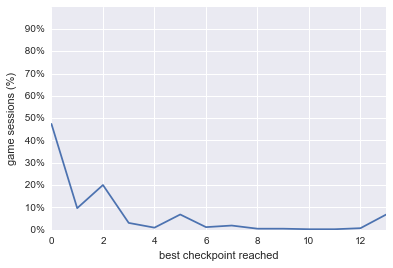

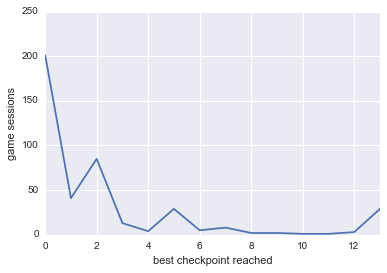

In [39]:
startTutorial1Count = sessionscount
neverReachedGameSessionCount = startTutorial1Count - maxCheckpointCountsTableCount
fullMaxCheckpointCounts = maxCheckpointCounts
fullMaxCheckpointCounts['Start'] = neverReachedGameSessionCount
fullMaxCheckpointCountsTable = pd.DataFrame({"fullMaxCheckpoint" : fullMaxCheckpointCounts.values})

genericTreatment( fullMaxCheckpointCountsTable, "best checkpoint reached", "game sessions", 0, startTutorial1Count, False, True )

print '\nfullMaxCheckpointCountsTable=\n{0}'.format(fullMaxCheckpointCountsTable)
fullMaxCheckpointCountsTable.describe()

## Duration

Duration of playing sessions

In [47]:
durations = players.groupby("sessionId").agg({ "serverTime": [ np.min, np.max  ] })
durations["duration"] = pd.to_datetime(durations["serverTime"]["amax"]) - pd.to_datetime(durations["serverTime"]["amin"])
durations["duration"] = durations["duration"].map(lambda x: np.timedelta64(x, 's'))
durations = durations.sort_values(by=['duration'], ascending=[False])
durations.head()

serverTime  \
                                                          amin   
sessionId                                                        
b5ab445a-56c9-4c5b-a6d0-86e8a286cd81  2017-06-02T12:06:44.465Z   
f168b30d-b76b-4eb1-91ea-206567329a83  2017-06-10T09:09:19.729Z   
d708b04d-978a-4497-ad30-3dce9ead2b4c  2017-06-09T16:24:15.814Z   
f9bc2bce-8900-4e91-9c5f-077218ff8200  2017-06-04T10:50:20.217Z   
054a96ca-c2f1-4967-9b77-6ce4c33c9d33  2017-06-07T12:20:06.263Z   

                                                                      duration  
                                                          amax                  
sessionId                                                                       
b5ab445a-56c9-4c5b-a6d0-86e8a286cd81  2017-06-09T12:20:39.390Z 7 days 00:13:54  
f168b30d-b76b-4eb1-91ea-206567329a83  2017-06-10T10:41:04.626Z 0 days 01:31:44  
d708b04d-978a-4497-ad30-3dce9ead2b4c  2017-06-09T17:01:31.474Z 0 days 00:37:15  
f9bc2bce-8900-4e91-9c5f-077218ff8200  2017-06-04T11:19:06.085Z 0 days 00:28:45  
054a96ca-c2f1-4967-9b77-6ce4c33c9d33  2017-06-07T12:30:39.856Z 0 days 00:10:33

Duration plot

serverTime  \
                                                          amin   
sessionId                                                        
054a96ca-c2f1-4967-9b77-6ce4c33c9d33  2017-06-07T12:20:06.263Z   
98cb65d7-bf34-4d44-827c-dcd1459c9cdd  2017-04-26T17:55:20.645Z   
8873559b-7ecc-4b7e-80be-7ae289547969  2017-06-09T10:54:39.115Z   
265dfb54-9d18-4ebd-905f-efc4d162bf01  2017-04-27T17:46:38.510Z   
c7bf82a9-f356-445a-a674-2c106c880424  2017-05-02T10:34:21.284Z   

                                                               duration  \
                                                          amax            
sessionId                                                                 
054a96ca-c2f1-4967-9b77-6ce4c33c9d33  2017-06-07T12:30:39.856Z 00:10:33   
98cb65d7-bf34-4d44-827c-dcd1459c9cdd  2017-04-26T18:01:49.575Z 00:06:28   
8873559b-7ecc-4b7e-80be-7ae289547969  2017-06-09T11:00:05.346Z 00:05:26   
265dfb54-9d18-4ebd-905f-efc4d162bf01  2017-04-27T17:52:00.229Z 00:05:21   
c7bf82a9-f356-445a-a674-2c106c880424  2017-05-02T10:39:42.008Z 00:05:20   

                                     duration_seconds duration_rank  
                                                                     
sessionId                                                            
054a96ca-c2f1-4967-9b77-6ce4c33c9d33              633             1  
98cb65d7-bf34-4d44-827c-dcd1459c9cdd              388             2  
8873559b-7ecc-4b7e-80be-7ae289547969              326             3  
265dfb54-9d18-4ebd-905f-efc4d162bf01              321             4  
c7bf82a9-f356-445a-a674-2c106c880424              320             5

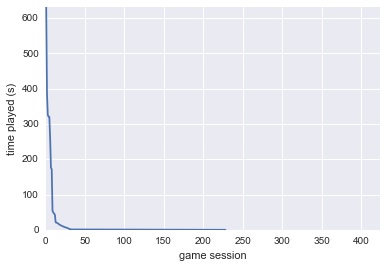

In [41]:
durations.loc[:,'duration']
durations = durations[4:]
durations["duration_seconds"] = durations["duration"].map(lambda x: pd.Timedelta(x).seconds)
maxDuration = np.max(durations["duration_seconds"])
durations["duration_rank"] = durations["duration_seconds"].rank(ascending=False)
durations.plot(x="duration_rank", y="duration_seconds")
plt.xlabel("game session")
plt.ylabel("time played (s)")
plt.legend('')
plt.xlim(0, sessionscount)
plt.ylim(0, maxDuration)
durations["duration_seconds"].describe()
durations.head()